In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np

In [6]:
from astropy.io import fits
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np

In [7]:
# import LAM library for logbook, data analysis...
from pfs.lam.sacFileHandling import *

In [8]:
from matplotlib import style
style.use('ggplot')

In [9]:
imgPath = '/home/pfs/shared/Pictures/SM1'

In [10]:
smId = 2

In [11]:
def correlate(reference, image):
    return register_translation(reference, image, 100)

    
def sacShift(filelist, duplicate):
    __, reference = stackedImage(filelist, 0, duplicate=duplicate)
    res = []
    
    for i in range(len(filelist)//duplicate):
        hdr, image = stackedImage(filelist, i, duplicate=duplicate)
        ccdPos = round(hdr['ait.sac.ccd.position'], 1)
        pentaPos= round(hdr['ait.sac.penta.position'], 1)

        shift, error, diffphase = correlate(reference=reference, image=image)
        res.append((ccdPos,pentaPos,shift[0], shift[1]))
        
    return pd.DataFrame(data=res, columns=['ccdPosition', 'pentaPosition', 'shift_x', 'shift_y'])


def getDescription(experimentId):
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
    dateobs = getDateObs(experimentId=experimentId)

    description = pd.DataFrame([(experimentId, dateobs, len(filelist), visitStart, visitEnd, duplicate)],
                               columns=['experimentId', 'dateobs', 'nbImages', 'visitStart', 'visitEnd', 'duplicate'])

    return description

In [12]:
import sqlite3
import pandas as pd

engine = 'file:///data/ait/experimentLog-sac.db?mode=ro'
#engine = 'file:///data/ait/experimentLog.db?mode=ro'

query = "select * from Experiment where type='sacAlignment' order by experimentId desc"
query = "select * from Experiment where type='sacExpose' order by experimentId desc"

#query = "select experimentId,obsdate,name,visitStart,visitEnd,type,cmdStr,comments,anomalies from Exposure inner join Experiment on Experiment.visitStart=Exposure.visit order by experimentId desc"

conn = sqlite3.connect(engine, uri=True)
df = pd.read_sql_query(query, conn,index_col='experimentId')

In [2]:
df

,name,visitStart,visitEnd,type,cmdStr,comments,anomalies,startdate,cmdError
experimentId,,,,,,,,,
253,SM2 SAC align - manuel,8019,8028,sacExpose,spsait sac expose exptime=1.0 duplicate=10,-350 focus=6,,2020-09-01T13:56:15,
252,SM2 SAC align - manuel,8009,8018,sacExpose,spsait sac expose exptime=1.0 duplicate=10,450 focus=6,,2020-09-01T13:47:48,
251,SM2 SAC align - manuel,7999,8008,sacExpose,spsait sac expose exptime=1.0 duplicate=10,450 focus=0,,2020-09-01T13:19:53,
250,SM2 SAC align - manuel,7995,7998,sacExpose,spsait sac expose exptime=1.0 duplicate=10,450 focus=0,wrong pos,2020-09-01T13:18:54,text='command failed: UserWarning('Stop reques...
249,SM2 SAC align - manuel,7985,7994,sacExpose,spsait sac expose exptime=1.0 duplicate=10,-356 focus=0,,2020-09-01T13:12:28,
248,SM2 SAC align - manuel,7975,7984,sacExpose,spsait sac expose exptime=1.0 duplicate=10,-356,,2020-09-01T13:00:04,
247,SM2 SAC align - manuel,7965,7974,sacExpose,spsait sac expose exptime=1.0 duplicate=10,-356,,2020-09-01T12:57:47,
246,SM2 SAC align - manuel,7955,7964,sacExpose,spsait sac expose exptime=1.0 duplicate=10,450,,2020-09-01T12:44:48,
245,SM2 SAC align - manuel,7946,7954,sacExpose,spsait sac expose exptime=1.0 duplicate=10,,,2020-09-01T12:42:37,text='command failed: UserWarning('Stop reques...


## Data required : 
To be able to find the right focus, some data acquisition is required.

you need to use ics_spsaitActor to perform your sequence

example : <b>sac align exptime=1.0 focus=0 lowBound=-450 upBound=450 nbPosition=10 duplicate=3</b>

-450 : 450 is the range of the pentaprism linear stage

focus is the position of the ccd linear stage

the goal here is to take several sequences for difference focus value, here we have taken data for [0,2,4,6,8]


## Input Parameters : 
The only parameters needed is the experimentIds that match your data acquisition sequence

In [59]:
experimentStart = 246 #219 #185 #the first experimentId is 12
experimentEnd = 251# 223#189    #the last experimentId is 16
ignore = [250]

In [60]:
dfs = []

for experimentId in range(experimentStart, experimentEnd+1):
    if experimentId in ignore:
        continue
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
#    duplicate = 2
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    df = sacShift(filelist=filelist, duplicate=duplicate)
    df['experimentId'] = experimentId
    dfs.append(df)

cube = pd.concat(dfs)

In [24]:
dfs = []
filelist = []
for experimentId in [252,253]:
    #if experimentId in ignore:
    #    continue
        
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
#    duplicate = 2
    filelist += constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    
df = sacShift(filelist=filelist, duplicate=duplicate)
#df['experimentId'] = experimentId
#    dfs.append(df)

#cube = pd.concat(dfs)

In [25]:
df

,ccdPosition,pentaPosition,shift_x,shift_y
0,6.0,450.1,0.00,0.00
1,6.0,-350.3,13.69,-47.98


In [62]:
descriptions = pd.concat([getDescription(experimentId) for experimentId in range(experimentStart, experimentEnd+1)])
descriptions = descriptions.set_index('experimentId')
descriptions

,dateobs,nbImages,visitStart,visitEnd,duplicate
experimentId,,,,,
246,2020-09-01T12:44:48,10,7955,7964,10
247,2020-09-01T12:57:47,10,7965,7974,10
248,2020-09-01T13:00:04,10,7975,7984,10
249,2020-09-01T13:12:28,10,7985,7994,10
250,2020-09-01T13:18:54,4,7995,7998,10
251,2020-09-01T13:19:54,10,7999,8008,10


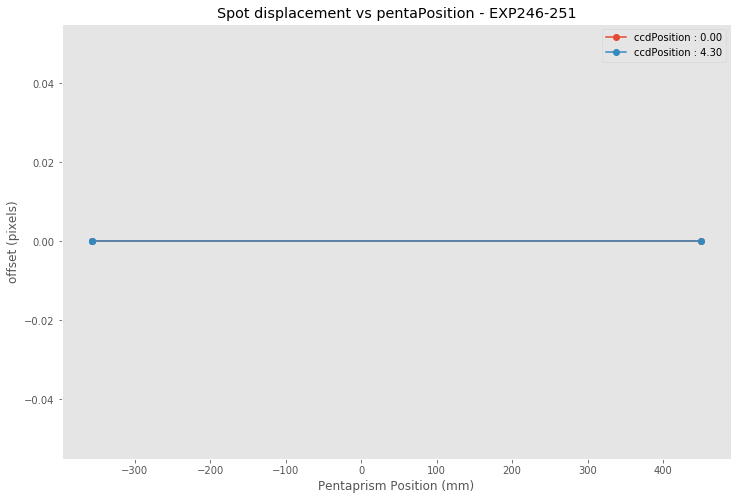

In [72]:
plt.figure(figsize=(12,8))
plt.xlabel('Pentaprism Position (mm)')
plt.ylabel('offset (pixels)')

for ccdPosition, df in cube.groupby('ccdPosition'):
    plt.plot(df['pentaPosition'], df['shift_x'], 'o-', label='ccdPosition : %.2f'%ccdPosition)
    
plt.title('Spot displacement vs pentaPosition - EXP%i-%i'%(experimentStart, experimentEnd))
plt.grid()
plt.legend()

if False:
    plt.savefig(os.path.join(imgPath, 'SM1_SACALIGN_EXP%i-%i_SPOT_DISPLACEMENT.png'%(experimentStart, experimentEnd)))

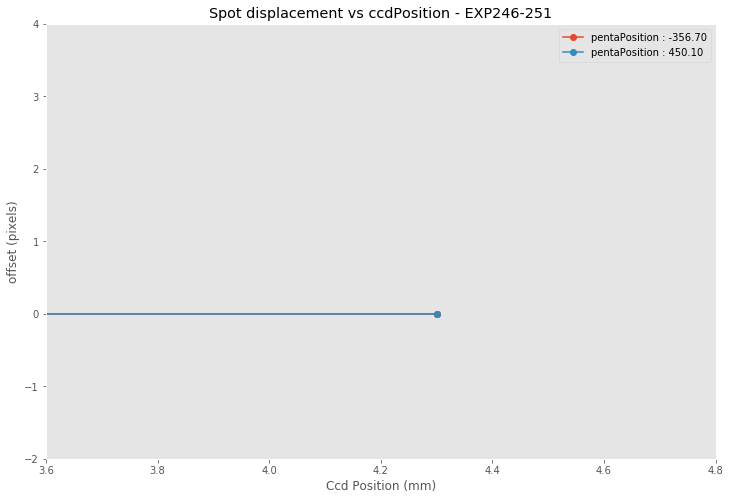

In [73]:
plt.figure(figsize=(12,8))
plt.xlabel('Ccd Position (mm)')
plt.ylabel('offset (pixels)')


for pentaPosition, df in cube.groupby('pentaPosition'):
    plt.plot(df['ccdPosition'], df['shift_x'], 'o-', label='pentaPosition : %.2f'%pentaPosition)
    
plt.title('Spot displacement vs ccdPosition - EXP%i-%i'%(experimentStart, experimentEnd))
plt.grid()
plt.legend()
plt.xlim(3.6,4.8)
plt.ylim(-2, 4)

if False:
    plt.savefig(os.path.join(imgPath, 'SM1_SACALIGN_EXP%i-%i_SPOT_DISPLACEMENT.png'%(experimentStart, experimentEnd)))

In [74]:
data = []
for ccdPosition, df in cube.groupby('ccdPosition'):
    [slope, offset] = np.polyfit(df['pentaPosition'], df['shift_x'], deg=1)
    data.append((ccdPosition, slope))
    
df = pd.DataFrame(data=data, columns=['ccdPosition', 'slope'])

ValueError: not enough values to unpack (expected 1, got 0)

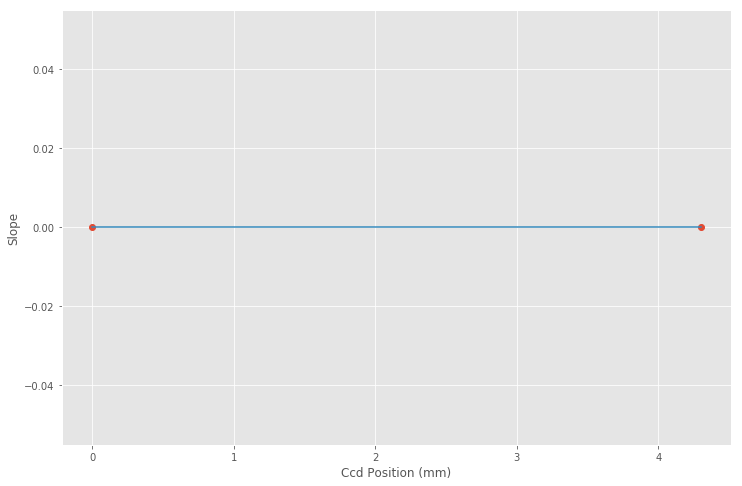

In [75]:
x = np.arange(np.min(df['ccdPosition']), np.max(df['ccdPosition'])+0.01, 0.01)
popt = np.polyfit(df['ccdPosition'], df['slope'], deg=1)

plt.figure(figsize=(12,8))
plt.xlabel('Ccd Position (mm)')
plt.ylabel('Slope')

plt.plot(df['ccdPosition'], df['slope'], 'o')
plt.plot(x, np.polyval(popt, x), '-')

[calc_focus] = np.roots(popt)
plt.vlines(x=calc_focus, ymin=np.min(df['slope']), ymax=np.max(df['slope']))
plt.title('Calculated Focus = %.3f mm - EXP%i-%i'%(calc_focus, experimentStart, experimentEnd))
plt.grid()

if True:
    plt.savefig(os.path.join(imgPath, 'SM1_SACALIGN_EXP%i-%i_CALC_FOCUS.png'%(experimentStart, experimentEnd)))

In [76]:
f = 1497.
pix_size = 4.539e-3
defoc = []

for ccdPosition, df in cube.groupby('ccdPosition'):
    for index, row in df.iterrows():
        ref = row['shift_x']
        penta = row['pentaPosition']
        for ind, row2 in df[index+1:].iterrows():
            shift = (row2['shift_x']-ref)* pix_size * f / ((row2["pentaPosition"]-penta)/10)
            defoc.append((ccdPosition,shift))

defoc = pd.DataFrame(defoc, columns=['x', 'y'])
p = np.polyfit(defoc.x, defoc.y, deg=1)

/software/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/software/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


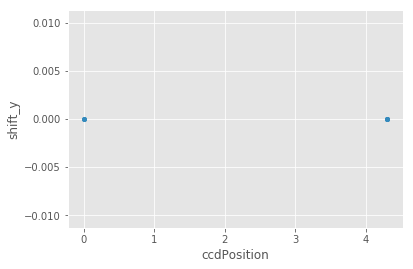

In [77]:
cube.plot(x="ccdPosition", y="shift_y", kind="scatter")

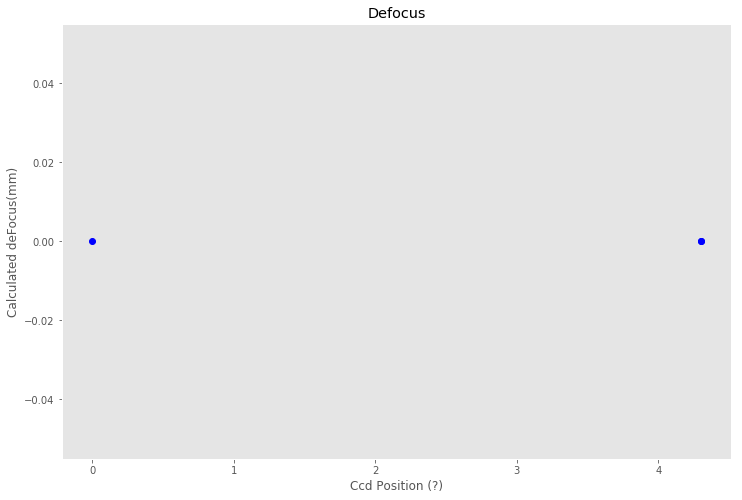

In [78]:
vect = np.arange(defoc.x.iloc[0], defoc.x.iloc[-1], 0.01)
plt.figure(figsize=(12,8))
plt.xlabel('Ccd Position (?)')
plt.ylabel('Calculated deFocus(mm)')
plt.title('Defocus')

plt.plot(defoc.x, defoc.y, 'bo')
plt.plot(vect, np.polyval(p, vect), 'b-')
plt.grid()

In [79]:
defoc["best"] = defoc.x + (1/0.735) * defoc.y

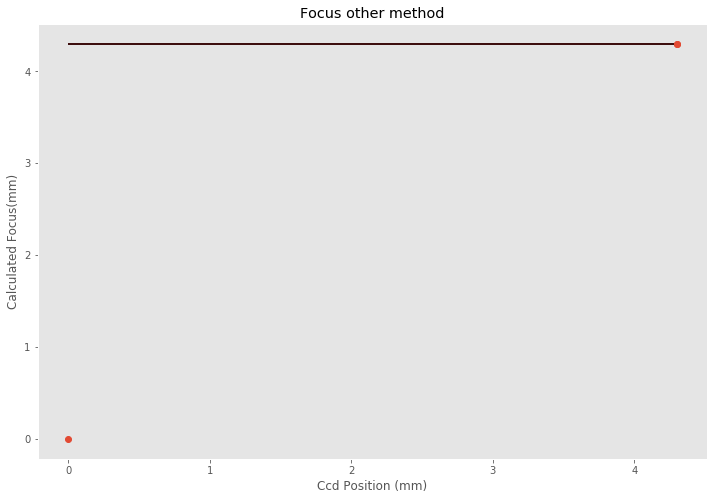

In [80]:
plt.figure(figsize=(12,8))
plt.xlabel('Ccd Position (mm)')
plt.ylabel('Calculated Focus(mm)')
plt.title('Focus other method')

plt.plot(defoc.x,defoc["best"], 'o')
plt.hlines(defoc.query("0<best<10 ").best.mean(), xmin=defoc.x.min(), xmax=defoc.x.max(), colors="r")
plt.hlines(defoc.query("0<best<10 ").best.median(), xmin=defoc.x.min(), xmax=defoc.x.max())

plt.grid()

In [81]:
print(np.median(foc), np.std(foc))

NameError: name 'foc' is not defined

In [82]:
t = defoc.best.dropna()

In [83]:
defoc.query("0<best<10 ").best.std()

0.0

In [84]:
defoc.query("0<best<10 ").best.mean()

4.3

In [85]:
defoc.query("0<best<10 ").best.median()

4.3